In [2]:
# automatically show plots inside the notebook
%matplotlib inline  

# reload all modules before executing code
%load_ext autoreload
%autoreload 2  

In [1]:
# you will use this notebook as a basis to walk us through what you did
import pandas as pd
import matplotlib.pyplot as plt

In [231]:
features = pd.read_csv("/Users/pbarot/Downloads/sickness/features.csv")
labels = pd.read_csv("/Users/pbarot/Downloads/sickness/labels.csv")

In [5]:
print(features.head(), labels.head())

   Patient ID  Feature0  Feature1  Feature2  Feature3  Feature4  Feature5  \
0           1       743      3594        81     23154       887       491   
1           2       249      1523       373     60306      1347      1016   
2           4       150       815        88     54361      1558       452   
3           5       376      2095       276     58681      1307       814   
4           7        78      1946       109     34454      1577       415   

   Feature6  Feature7  Feature8     ...      Feature677  Feature678  \
0       368      1322     14624     ...        0.051950    0.057096   
1       201      1586     45525     ...        0.023671    0.026299   
2       105      1758     47862     ...        0.030360    0.032339   
3       241      1527     45351     ...        0.024164    0.026028   
4       513      1785     26612     ...        0.050253    0.051808   

   Feature679  Feature680  Feature681  Feature682  Feature683  Feature684  \
0    4.309440    0.827737    0.81

In [36]:
print(len(set(features['Patient ID']).intersection(set(labels['Patient ID']))))
print(max(dataset_df['Patient ID']))


288
9998


## All patient IDs are present in both sets, let's make an inner join and make one big dataset

In [9]:
dataset_df = features.merge(labels, on = 'Patient ID', how = 'inner')
dataset_df.head()
print (len(dataset_df))

288


## Let's make a plot to visualize the label better

In [10]:
color_map = ['r' if i==1 else 'b' for i in dataset_df['Sickness'].tolist()]

In [11]:
color_map[0:5]

['b', 'b', 'r', 'b', 'b']

In [18]:
dataset_df['color map'] = color_map

(0, 600)

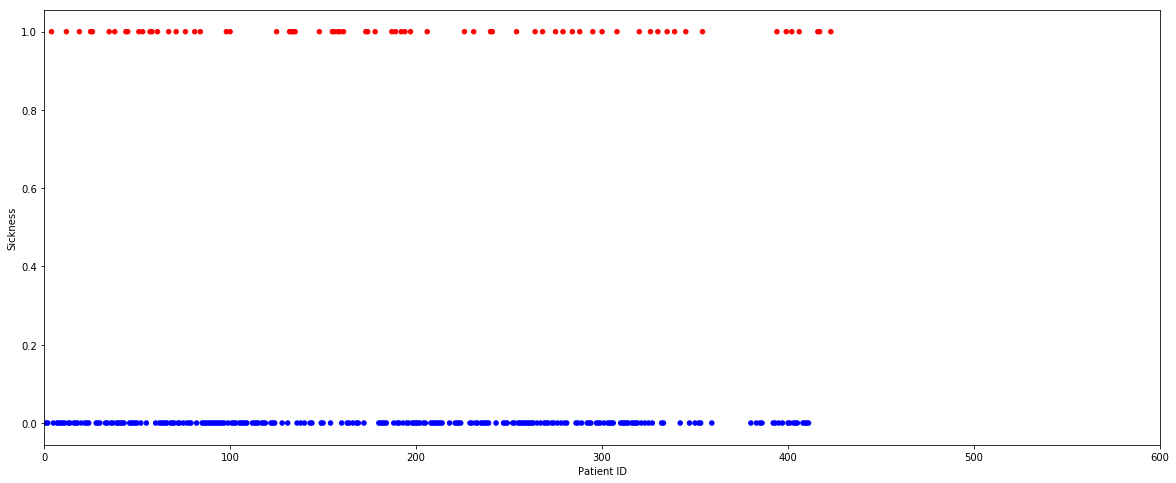

In [50]:
dataset_df.plot(color= dataset_df['color map'],
                x = 'Patient ID',
                y='Sickness',
                figsize=(20,8),
                alpha = 1,
                kind = 'scatter')
#let's just view the majority of the cluster
plt.xlim(0,600)

## Lots of unsick people, potential class imbalance

Text(0,0.5,'Count')

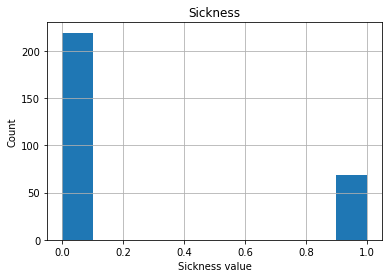

In [33]:
dataset_df.hist('Sickness')
plt.xlabel("Sickness value")
plt.ylabel("Count")

## Let's do some binary classification. Fitting and visualizing a decision tree

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_df.drop(['Sickness','color map'], axis=1), dataset_df['Sickness'],
    test_size=0.33, random_state=75)

In [142]:
clf = DecisionTreeClassifier(random_state=0)

In [143]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [144]:
predicted_values = clf.predict(X_test)

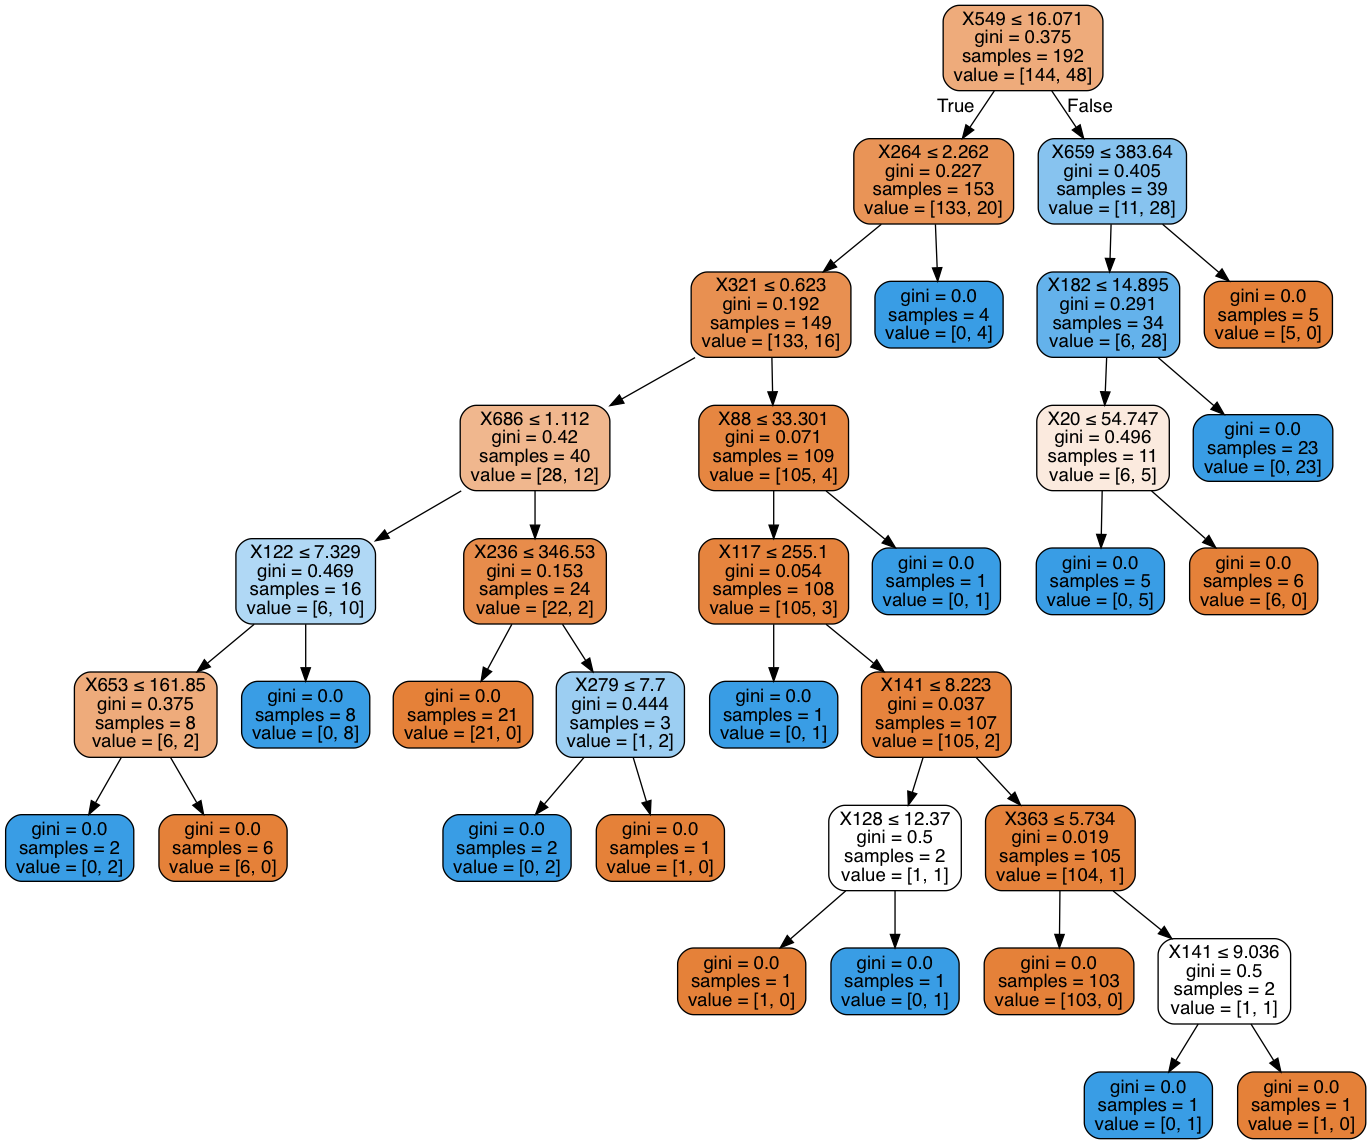

In [145]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## this is probably how it chose to make it classifications (from around the average of feature 549)

In [146]:
import numpy as np
np.mean(dataset_df['Feature549'])

16.483023821645293

In [147]:
max(dataset_df['Feature549']), min(dataset_df['Feature549'])

(25.84978322982788, 13.756467342376707)

In [148]:
cf_report = classification_report(y_true = y_test, y_pred=predicted_values)
print (cf_report)

             precision    recall  f1-score   support

          0       0.86      0.76      0.81        75
          1       0.40      0.57      0.47        21

avg / total       0.76      0.72      0.73        96



## Try a Random Forest with 10 sub-trees

In [149]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
predicted_values = rf.predict(X_test)

In [150]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [151]:
cf_report = classification_report(y_true = y_test, y_pred=predicted_values)
print (cf_report)

             precision    recall  f1-score   support

          0       0.83      0.85      0.84        75
          1       0.42      0.38      0.40        21

avg / total       0.74      0.75      0.75        96



## Not a huge improvement even with a generally better model for binary decisioning

### Potentially due to a class imbalance. Let's try sampling the training set to have an equal split (leave the test set untouched)

In [152]:
new_training_set = X_train.reset_index().merge(y_train.reset_index(), how='inner', on='index')

In [153]:
positive_class = new_training_set[new_training_set['Sickness'] == 1]
negative_class = new_training_set[new_training_set['Sickness'] == 0]
print(len(positive_class), len(negative_class))

48 144


### Upsample to the same length of the negative class

In [154]:
positive_class = positive_class.sample(len(negative_class), replace = 'True')

In [155]:
print(len(positive_class), len(negative_class))

144 144


## concat the two again to recreate the training set

In [156]:
new_training_set = pd.concat([positive_class, negative_class], axis = 0)

In [157]:
new_training_set.head()

,index,Patient ID,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,...,Feature678,Feature679,Feature680,Feature681,Feature682,Feature683,Feature684,Feature685,Feature686,Sickness
3,200,295,120,808,124,87470,1448,378,112,1564,...,0.017880,93.136957,1.559276,0.545793,0.969882,0.627596,0.898375,1.120726,0.955823,1
92,15,19,579,3338,82,40802,825,812,342,1170,...,0.028675,7.009783,0.959414,0.556667,0.874713,0.523461,0.728621,1.053608,0.670438,1
171,186,275,78,2127,52,74728,1014,96,432,1149,...,0.015376,27.918718,0.807969,0.576939,1.229254,0.640130,0.934277,1.192801,1.024584,1
28,9,12,26,3198,21,66143,854,78,468,970,...,0.014665,16.811784,0.673950,1.093552,0.667620,0.614909,0.586856,0.917970,0.717492,1
181,237,326,480,3709,58,52001,1175,143,761,1447,...,0.027826,10.211857,1.156549,0.695521,1.349999,0.647122,1.168602,1.202837,1.063408,1


In [158]:
X_train, _, y_train, _ = train_test_split(
    new_training_set.drop(['Sickness','index'], axis=1), new_training_set['Sickness'],
    test_size=0.33, random_state=75)

In [159]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

192 192
96 96


In [163]:
from collections import Counter
print(Counter(y_train), Counter(y_test))

Counter({1: 102, 0: 90}) Counter({0: 75, 1: 21})


In [164]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
predicted_values = rf.predict(X_test)

In [165]:
cf_report = classification_report(y_true = y_test, y_pred=predicted_values)
print (cf_report)

             precision    recall  f1-score   support

          0       0.85      0.85      0.85        75
          1       0.48      0.48      0.48        21

avg / total       0.77      0.77      0.77        96



## plotting the feature importances for the RF

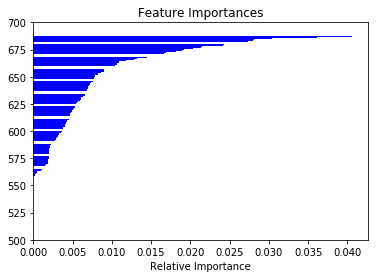

In [173]:
#features = features.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), features[indices])
plt.ylim(500,700)
plt.xlabel('Relative Importance')
plt.figure(figsize=(20,5))
plt.show()

## It is ordered from 0-689. Clearly, features 575 onwards are most valued by the RF, the others are negligible

In [179]:
features.columns

Index(['Patient ID', 'Feature0', 'Feature1', 'Feature2', 'Feature3',
       'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8',
       ...
       'Feature677', 'Feature678', 'Feature679', 'Feature680', 'Feature681',
       'Feature682', 'Feature683', 'Feature684', 'Feature685', 'Feature686'],
      dtype='object', length=688)

In [232]:
drop_columns = ["Feature{}".format(i) for i in list(range(0,550))]
features = features[features.columns.difference(drop_columns)]

In [233]:
important_feats = features.merge(labels, how = 'inner', on ='Patient ID')

## Get the labels and features again

In [234]:
labels = important_feats[['Sickness']]
feats = important_feats.drop('Sickness', axis = 1)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(
    feats, labels,
    test_size=0.33, random_state=75)

In [287]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=6)
rf.fit(X_train, y_train)
predicted_values = rf.predict(X_test)
cf_report = classification_report(y_true = y_test, y_pred=predicted_values)
print (cf_report)

/Users/Lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


             precision    recall  f1-score   support

          0       0.85      0.95      0.89        75
          1       0.67      0.38      0.48        21

avg / total       0.81      0.82      0.80        96



## With some changes in the experimentation, we have been able to change the class 1 precision from 42% to 67%.